# The CityLearn Smart-Grid Environment with MARL Soft-Actor-Critic
This notebook is a complete example of implementing the Decentralized Soft Actor-Critic RL method on the City-Learn Smart-Grid environment of the Neurips 2022 challenge. The notebook consists of two parts:
1. A comprehensive explanation and code example of how to run the CityLearn smart-grid environment.
2. A complete training implementation of the Model-Free RL SAC algorithm in a decentralized setting on the CityLearn smart-grid environment with an evaluation process.


## Introduction

**The environment** consists of a household district simulation based on real measured data. The data for each household (building) was measured from an actual building with solar generation capabilities somewhere in California for a full year, resulting in 8760 points of data, one for each hour. In the environment, each building in the district is given a full-year measured electricity consumption and production profile together with some electricity storage abilities in the form of a battery. All the buildings in the environment are directly connected to the electrical grid without connecting to other buildings.

**The objective** in the environment is to minimize the district's electricity price paid and the emission of CO2 usage using the buildings' batteries. To that end, each building needs to find a policy for using its battery (charge/discharge) in such a way that contributes to the objective. The utility metric depends on the electricity prices and carbon emissions of all the buildings in the district. 

![](figures/city_learn_district.png)

**In the interactive case**, where buildings can interact with one another, finding a useful policy for each building is a very complex task because the dimension of the policy space is exponential in the number of buildings in the district. 

Therefore, we suggest implementing a **Multi-Agent Model-Free Reinforcement Learning** approach to tackle this problem and find a good policy for battery usage for each building in the district. 

## A Short Explanation of the CityLearn Environment 
#### Outline of the next few cells
1. Defining the CityLearn environment
2. Explaining the Observation Space
3. Explaining the Action Space
4. Operating in the environment
5. Automatic evaluation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import copy as cp
import time
from gym.spaces.box import Box
import torch as T
import random

from citylearn.citylearn import CityLearnEnv
from agents.rl_controller import RlDecentralizedCoordinator as Coordinator
from agents.sac_utils import Agent as SacAgent
from utils import plot_interval_results, plot_scores

/Users/royelkabetz/opt/miniconda3/envs/smart_grid_rl_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Seed Everything for Experimental Reproducibility
As part of the training process, it is essential to be able to reproduce the experimental results. For that aim, we **seed** every random function in the process at the beginning of each experiment.

In [2]:
# seed everything for experimental reproducibility
SEED = 216
np.random.seed(SEED)    # numpy
T.manual_seed(SEED)     # torch
random.seed(SEED)       # random

### Useful Utilities
Here we got some useful utility functions and classes that will help us along the training process.

In [3]:
# Define the number of episodes being played and the schema
class Constants:
    episodes = 1
    schema_path = './data/citylearn_challenge_2022_phase_1/schema.json'

In [4]:
# Reformat the action space into a dictionary from a list
def action_space_to_dict(aspace):
    """ Only for box space """
    return {"high": aspace.high,
            "low": aspace.low,
            "shape": aspace.shape,
            "dtype": str(aspace.dtype)
            }


# Reset the environment and create the observation dictionary with all environment info
def env_reset(env):
    observations = env.reset()
    action_space = env.action_space
    observation_space = env.observation_space
    building_info = env.get_building_information()
    building_info = list(building_info.values())
    action_space_dicts = [action_space_to_dict(asp) for asp in action_space]
    observation_space_dicts = [action_space_to_dict(osp) for osp in observation_space]
    obs_dict = {"action_space": action_space_dicts,
                "observation_space": observation_space_dicts,
                "building_info": building_info,
                "observation": observations}
    return obs_dict

### Define the Environment

The first thing we need to do is create a CityLearn environment. The environment is defined using a json schema and a dataset which can be found in the data directory.

In [5]:
env = CityLearnEnv(schema=Constants.schema_path)

### Observation Space

The observation space is given from the data of the environment. This is what the agent receives from the environment in order to decide which action to take at each time step.

Based on our environment, the observation space is five-dimensional, corresponding to the district's number of buildings. Each building has its observation, which consists of a 1D array with 28 features for each time step of the environment (a single time step is 1 hour). Therefore our environment has `5x28` dimensions.

1. Use `env.observation_space` to explore the entire environment
2. Use `env.observation_space[building_id]` to explore the envrionment of a particular building (index 0 for building 1)

In [6]:
# sample some observations
for building in range(5):
    print(f'Sample an observation for building {building}:\n', 
          f'{env.observation_space[building].sample()}')


Sample an observation for building 0:
 [ 1.0041202e+00  6.9030099e+00  1.7309368e+01  7.9316101e+00
  2.8247023e+01  1.9145031e+01  2.1554449e+01  2.7583908e+01
  3.5563801e+01  6.2745670e+01  2.2404606e+01  4.2963696e+01
  8.0774194e+02  1.7109689e+02  2.6027069e+02  4.8055157e+02
  9.2768457e+02  4.9308834e+01  7.5437036e+00  1.2072551e+00
  5.9778214e+00  7.1958057e+02  7.3193085e-01 -6.3731102e+01
  2.1135232e-01  9.3906444e-01  2.9882418e-02  1.5325501e+00]
Sample an observation for building 1:
 [ 6.5646615e+00  1.2528250e+00  3.7960081e+00  8.1919880e+00
  1.6928061e+01  2.3578314e+01  1.0270085e+01  4.9488682e+01
  7.6377708e+01  8.0039009e+01  3.4156647e+01  2.3425671e+02
  3.3165488e+02  7.5144464e+02  1.3586971e+02  6.1697388e+02
  4.9226382e+02  7.6846100e+02  5.0971924e+02 -6.4306021e-01
  3.3480453e+00  1.4805725e+02 -6.4885372e-01  1.5983430e+02
  2.2831190e-01 -3.2479849e-01  1.3797994e+00  8.7531132e-01]
Sample an observation for building 2:
 [ 8.5708122e+00  5.3478985e

Notice that each one of the observation samples above has 28 features, where each one of them corresponds to a specific, measurable parameter in the environment. For example, the observation of building-1 with the description of the observation parameters is reachable via
`env.buildings[0].observations`

In [7]:
for parameter, value in env.buildings[0].observations.items():
    print(parameter + ':', value)

month: 7
day_type: 7
hour: 24
outdoor_dry_bulb_temperature: 20.0
outdoor_dry_bulb_temperature_predicted_6h: 18.3
outdoor_dry_bulb_temperature_predicted_12h: 22.8
outdoor_dry_bulb_temperature_predicted_24h: 20.0
outdoor_relative_humidity: 84.0
outdoor_relative_humidity_predicted_6h: 81.0
outdoor_relative_humidity_predicted_12h: 68.0
outdoor_relative_humidity_predicted_24h: 81.0
diffuse_solar_irradiance: 0.0
diffuse_solar_irradiance_predicted_6h: 25.0
diffuse_solar_irradiance_predicted_12h: 964.0
diffuse_solar_irradiance_predicted_24h: 0.0
direct_solar_irradiance: 0.0
direct_solar_irradiance_predicted_6h: 100.0
direct_solar_irradiance_predicted_12h: 815.0
direct_solar_irradiance_predicted_24h: 0.0
carbon_intensity: 0.1707244126403808
non_shiftable_load: 2.2758
solar_generation: 0.0
electrical_storage_soc: 0.0
net_electricity_consumption: 2.2758
electricity_pricing: 0.22
electricity_pricing_predicted_6h: 0.22
electricity_pricing_predicted_12h: 0.22
electricity_pricing_predicted_24h: 0.22


**Note:** 

There are parameters which are obvious, like `net_electricity_consumption` or `hour`,  but there are also ones that are complicated to understand, like `outdoor_dry_bulb_temperature_predicted_24h`.
Because we adopt a **Model-Free RL** approach, there is no need to get into the characteristics of each one of these parameters at the moment, because we do not exploit that information in the solution.

Later, when we will present a **Rule-Based Agent** type of solution it would be very important to address each one of the useful features in the building's observation. 

### Action Space

The action space shows us the type of actions an agent can take along with the dimension and type (discrete or continuous) of each action. In the CityLearn challenge, the actions are continuous and one-dimensional in the range $[-1,1]$ for each building, where 1 means fully charging the battery and -1 means fully discharging the battery.

- Based on our environment, the environment's action space is five-dimensional, one for each action space of a building.
- A building's action space is of the form `[(-1,1), (1,), float32]`, which corresponds to a Gym Box object of the form `[(lower bound, upper bound), (dimension,), datatype]`.
- The __lower bound__ corresponds to the lowest or smallest value an action could take, while the __upper bound__ is the highest.
- Dimension stands for the number of features an action has, which in our case is 1 (use `action_space.sample()` to sample an action)
- Datatype is the data type of the action which in this case is a float.

The cell below illustrates the action space(s). Play with it to understand the actions.

`action_space.sample` produces a random actions

Note: You must pick an action space of a given building in order to sample an action value (use index, e.g. `action_space[0]`)

In [8]:
# Print and sample the action space for each building
for building_id, _ in enumerate(env.buildings):
    print(f'Building-{building_id} | action space: {env.action_space[building_id]} | ',
          f'Sampled action: {env.action_space[building_id].sample()}')

Building-0 | action space: Box(-1.0, 1.0, (1,), float32) |  Sampled action: [-0.42229947]
Building-1 | action space: Box(-1.0, 1.0, (1,), float32) |  Sampled action: [-0.02973612]
Building-2 | action space: Box(-1.0, 1.0, (1,), float32) |  Sampled action: [-0.23965417]
Building-3 | action space: Box(-1.0, 1.0, (1,), float32) |  Sampled action: [0.06540294]
Building-4 | action space: Box(-1.0, 1.0, (1,), float32) |  Sampled action: [-0.12221735]


### Taking an Action

As already explained with the action spaces, $n$ buildings will have $n$ actions, where each action corresponds to a single building. Therefore, 

- Action should be a List containing tuples (on for each building). Inside each tuple is a list conatining the action to be taken for a given building.
- In example, for a five buildings environment we can have 

``` python

Actions = [ ([0.0]), ([0.0]), ([0.0]), ([0.0]), ([0.0]) ]

```
a list of list is also acceptable

``` python

Actions = [ [0.0], [0.0], [0.0], [0.0], [0.0] ]

```

We take an action when we want to move one step ahead. We can do this using `env.step(action)`.

When we take an action the output contains a tuple with the following (same as a Gym environment):

1. Next State
2. Reward
3. Done (checks if the state is a Terminal State)
4. Information about the environment 

In [9]:
# Sample some actions
actions = [(env.action_space[building_id].sample()) for building_id, _ in enumerate(env.buildings)]
print(f'Here are some randomly sampled actions: \n')
for building_id, _ in enumerate(env.buildings):
    print(f' Building-{building_id} | Sampled action: {actions[building_id]}')


# let us step the environment foreward in time by "taking" the actions
next_state, rewards, done, info = env.step(actions)

# print 
print('\nHere are the resulted variables from env.step():')
print('\nNext States:')
for building_id, _ in enumerate(env.buildings):
    print(f' Building-{building_id} | Next State: {next_state[building_id]}')

print('\nRewards:')
for building_id, _ in enumerate(env.buildings):
    print(f' Building-{building_id} | Next State: {rewards[building_id]}')

print(f'\nDone: {done} \n')
print(f'\nInfo: {info}')


# obs_dict = env_reset(env)
# agent = OrderEnforcingAgent()
# print(agent.register_reset(obs_dict))
# env.step(agent.register_reset(obs_dict))

Here are some randomly sampled actions: 

 Building-0 | Sampled action: [-0.27515966]
 Building-1 | Sampled action: [0.41531745]
 Building-2 | Sampled action: [-0.79881275]
 Building-3 | Sampled action: [-0.88044894]
 Building-4 | Sampled action: [-0.9925485]

Here are the resulted variables from env.step():

Next States:
 Building-0 | Next State: [8, 1, 1, 20.1, 19.4, 22.8, 19.4, 79.0, 79.0, 71.0, 87.0, 0.0, 201.0, 966.0, 0.0, 0.0, 444.0, 747.0, 0.0, 0.1573190581037597, 0.8511666666666671, 0.0, 0.0, 0.8511666666666671, 0.22, 0.22, 0.22, 0.22]
 Building-1 | Next State: [8, 1, 1, 20.1, 19.4, 22.8, 19.4, 79.0, 79.0, 71.0, 87.0, 0.0, 201.0, 966.0, 0.0, 0.0, 444.0, 747.0, 0.0, 0.1573190581037597, 1.3706666666666665, 0.0, 0.38750054899560016, 4.028698321024577, 0.22, 0.22, 0.22, 0.22]
 Building-2 | Next State: [8, 1, 1, 20.1, 19.4, 22.8, 19.4, 79.0, 79.0, 71.0, 87.0, 0.0, 201.0, 966.0, 0.0, 0.0, 444.0, 747.0, 0.0, 0.1573190581037597, 1.0185241699218762e-07, 0.0, 0.0, 1.0185241699218762e-07,

### Evaluating Actions

After taking some actions we can evaluate the performance of our agent or agents in the environment.
Evalution is done using the next metric (utility)

$$
\begin{align}
    U &= \frac{C_{entry}}{C_{no-battery}} + \frac{G_{entry}}{G_{no-battery}}
\end{align}
$$
where $C_{entry}$ and $ C_{no-battery}$ are the district's total electricity cost with and without batteries respectively, and $G_{entry}$ and $G_{no-battery}$ are the district's total CO2 emission with and without batteries respectively. Therefore, if ones use a set of agents that always take the action `NOOP` (which is $0$), then, the utility will be equal to $2$. 

In [10]:
price_cost, emission_cost = env.evaluate()
print(f'The price cost is: {price_cost}')
print(f'The emission cost is: {emission_cost}')
print(f'The final Utility value is: {price_cost + emission_cost}')

The price cost is: 1.2089480488572193
The emission cost is: 1.1982510167204277
The final Utility value is: 2.4071990655776467


## Method
We tackle the problem using a __Model-Free RL__ approach with a __Soft Actor-Critic agent__.

### Soft Actor Critic Agent
I will not go over the theory details of SAC here; the interested reader can find the implementation details in [1]. SAC is a model-free RL algorithm where an agent learns a __policy__ to act in the environment according to __critic__ function that values states and actions in the environment, which is also learned in the process.

### Decentralized MARL
Recall that our angle of attack is a Multi-Agent Reinforcement Learning approach, so as a first step, we analyzed the environment and the interactions between the buildings. The mathematical analysis comes to our aid in choosing the optimal MARL approach to implement in this problem. MARL refers to all the multi-agent methods in the Centralized - Decentralized continuum. The mathematiccal analysis is cumbersome, therefore, the interested reader can find it in the following link [CityLearn mathematical analysis](mathematical_analysis.pdf).

Section 1.4 (in the mathematical analysis) analyzes the utility function characteristics. In section 1.2, a few bullets summarize the main results from that analysis and the environment code implementation. An important conclusion from the study is that __the buildings in the environment do not interact with one another__ (see the pdf for details). Therefore the optimal behavior for an individual building would result in a behavior that would be optimal for the whole district. Consequently, we can implement a decentralized multi-agent setting where a different single agent controls each building and can expect to come up with somewhat good results. 

Another important aspect is that the district is **almost** symmetric from the point of view of a single building (the differences between the building are their battery parameters, which are very similar). Therefore, one would expect that a single policy, copied for every building's agent, would result in a decent performance in the environment. The last also will allow us to train the agents in fewer steps and with very little computation. This is an essential aspect of this solution that will enable us to train the agents locally on a laptop with 16 GB RAM, while remembering that we tackle a multi-agent problem that should be exponentially complex in the number of agents.

### Decentralized SAC Implementation
The critical implementation details of the method are as follows:
- We used the RL algorithm SAC as presented in [1].
- We initialized a single SAC agent with a __single__ Replay Buffer (the agents are assumed to be symmetric, and so are their transitions).
- Each building in the environment got a reference to the initialized agent, so they all shared the exact copy of the policy and buffer.
- The learning process was executed once per time-step. Therefore, $5$ new transitions were uploaded to the replay buffer at each time step, and a single learning step to the agent was executed.
- During the evaluation process, as in the training process, each building got its agent, which had a copy of the single policy we learned.

### The Reward Function
As part of the environment, one also needs to define the reward function for the agents (the reward is not given as a part of the environment) in the module [`get_reward.py`](rewards/get_reward.py). The reward function outputs a 5-valued array, one for each building, and is given with the following inputs
- `electricity_consumption`: the electricity consumption of each building in the district (positive means net consuming, negative means net producing). 
- `carbon_emission`: the amount of CO2, each building, emits.
- `electricity_price`: the price each building pays (if positive) or receives (if negative).
- `agent_ids`: a list of agent ids.

Therefore, we define the $i^{th}$ building's reward at time $t$ as a weighted sum of its __profit__ and __local stability__
$$
\begin{align}
    r_i^t &= \lambda_i\left[\underset{\text{revenue}}{\underbrace{\nu_i^t}} - \underset{\text{expenses}}{\underbrace{\Gamma_i^t}}\right]-(1-\lambda_i) \underset{\text{local stability factor}}{\underbrace{\vert P_i^t\vert}},
\end{align}
$$
where the profit is computed from the `electricity_price` variable, and the local stability is just the absolute value of the `electricity_consumption` variable. Note that we didn't use the `carbon_emission` variable because it depends on the `electricity_consumption` variable. When an agent consumes electricity from the grid, then the CO2 emission equals the amount of electricity consumption times a constant CO2 factor. 


So let us had on to the code...

### Create a Training Schema for RL

In [11]:
# Train agents
def train(train_constants, verbose=True, loading_dir=None,
          shared_agents=True):

    # seed everything for experimental reproducibility
    np.random.seed(train_constants.seed)  # numpy
    T.manual_seed(train_constants.seed)   # torch
    random.seed(train_constants.seed)     # random

    print("Starting local training")
    # Create a ne environment
    env = CityLearnEnv(schema=train_constants.schema_path)

    # Reset the environment
    obs_dict = env_reset(env)
    observations = obs_dict["observation"]

    # filter observation
    useful_observations = ['hour', 'carbon_intensity', 'non_shiftable_load', 'solar_generation',
                           'electrical_storage_soc', 'net_electricity_consumption', 'electricity_pricing']
    boolean_observation_filter = np.zeros(len(observations[0]), dtype=bool)
    for key, value in env.buildings[0].observation_metadata.items():
        if key in useful_observations and value is True:
            boolean_observation_filter[env.buildings[0].active_observations.index(key)] = value

    # Add coordinator
    ckpt_dir = 'tmp' if loading_dir is None else loading_dir
    rl_coordinator = Coordinator(SacAgent, obs_dict, **train_constants.sac_params, shared_agents=shared_agents,
                                 boolean_observation_filter=boolean_observation_filter, ckpt_dir=ckpt_dir)
    # load agents from checkpoint
    if loading_dir is not None:
        rl_coordinator.load_checkpoints()

    # Init local variables
    episodes_completed = 0
    num_steps = 0
    episode_metrics = []
    best_metric = np.inf

    # Define the agents' training time
    done = False

    # Start the training process
    while True:
        num_steps += 1

        # Take an action
        actions = rl_coordinator.compute_training_action(observations)

        # Step the environment and collect the observation, reward (user written reward), done and info
        observations_, rewards, done, info = env.step(actions)

        # Store transition in buffer
        rl_coordinator.store_joint_transition(observations, actions, rewards, observations_, done)

        # train the agents
        rl_coordinator.joint_learn()

        # step the observation
        observations = observations_

        # collect rewards and compute scores and average scores
        rl_coordinator.collect_scores(rewards)

        if num_steps % train_constants.compute_metric_interval == 0:
            # evaluate the agents
            metrics_t = env.evaluate()

            # collect the metrics
            rl_coordinator.collect_metrics(metrics_t)

            # print scores and metrics
            if verbose:
                rl_coordinator.print_scores_and_metrics(episodes_completed, num_steps)

        # evaluate the last episode and reset the environment
        if done:
            rl_coordinator.num_episodes += 1
            episodes_completed += 1
            metrics_t = env.evaluate()
            metrics = {"price_cost": metrics_t[0], "emission_cost": metrics_t[1]}
            if np.any(np.isnan(metrics_t)):
                raise ValueError("Episode metrics are nan, please contant organizers")
            episode_metrics.append(metrics)
            print(f"Episode complete: {episodes_completed} | Latest episode metrics: {metrics} |")

            # compute average scores
            rl_coordinator.compute_avg_scores()

            # save checkpoints of best agents
            rl_coordinator.save_checkpoints(eval_metrics=True)

            # Reset the environment
            done = False
            obs_dict = env_reset(env)
            rl_coordinator.init_score()
            observations = obs_dict["observation"]

        # terminate training and evaluation
        if episodes_completed == train_constants.episodes:
            rl_coordinator.save_checkpoints(eval_metrics=True)
            print(f"Training processes is done after {num_steps} steps - {episodes_completed} episodes.")
            break

    # print the episode mean evaluation score
    if len(episode_metrics) > 0:
        print("Average Price Cost:", np.mean([e['price_cost'] for e in episode_metrics]))
        print("Average Emission Cost:", np.mean([e['emission_cost'] for e in episode_metrics]))

    return env, rl_coordinator


In [12]:
# the SAC parameters
def sac_params():
    params = {
        "gamma": 0.99,
        "alpha": 7e-4,
        "beta": 7e-4,
        "lr_decay": None,
        "metric_diff_lr_decay": None,
        "fc1_dim": 128,
        "fc2_dim": 128,
        "memory_size": 100000,
        "batch_size": 16,
        "tau": 0.005,
        "update_period": 100,
        "reward_scale": 1.,
        "warmup": 1000,
        "reparam_noise_lim": 1e-6,
    }
    return params

In [13]:
# Define the number of episodes being played and the schema
class TrainConstants:
    episodes = 4
    schema_path = './data/citylearn_challenge_2022_phase_1/schema.json'
    compute_metric_interval = 400
    seed = 216
    sac_params = sac_params()
    name = f"__episodes_{episodes}__seed_{seed}__"

### Train the Agents
Choose the number of days you would like to train your agents for.

In [14]:
shared_agents = True
loading_dir = None
env, rl_coordinator = train(TrainConstants,
                            loading_dir=loading_dir,
                            shared_agents=shared_agents,
                            verbose=True)

Starting local training


/Users/royelkabetz/Git/nips_citylearn_challenge_2022/agents/sac_utils.py:220: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.done = np.zeros((self.buffer_size,), dtype=np.bool)
/Users/royelkabetz/Git/nips_citylearn_challenge_2022/agents/sac_utils.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1660136169395/work/torch/csrc/utils/tensor_new.cpp:204.)
  state = T.tensor([state], dtype=T.float).to(self.actor.device)


Initialize a shared decision maker for all agents.
| Episode:  0 | Steps:    400 | Price cost 1.0135 | Emission cost 1.0135 | Avg scores: [None, None, None, None, None] | Best scores: [-inf -inf -inf -inf -inf] |
| Episode:  0 | Steps:    800 | Price cost 1.0132 | Emission cost 1.0118 | Avg scores: [None, None, None, None, None] | Best scores: [-inf -inf -inf -inf -inf] |
| Episode:  0 | Steps:   1200 | Price cost 1.0593 | Emission cost 1.1751 | Avg scores: [None, None, None, None, None] | Best scores: [-inf -inf -inf -inf -inf] |
| Episode:  0 | Steps:   1600 | Price cost 1.1138 | Emission cost 1.3289 | Avg scores: [None, None, None, None, None] | Best scores: [-inf -inf -inf -inf -inf] |
| Episode:  0 | Steps:   2000 | Price cost 1.1037 | Emission cost 1.3110 | Avg scores: [None, None, None, None, None] | Best scores: [-inf -inf -inf -inf -inf] |
| Episode:  0 | Steps:   2400 | Price cost 1.0876 | Emission cost 1.2938 | Avg scores: [None, None, None, None, None] | Best scores: [-inf 

### Plot the Results of the Training Process
Below one can see three different plots:
- The first is a plot of the agents' scores along the training process (accumulative reward).
- The second is a plot of the district's utility (metric) as defined above along the training process.
- The third is a plot of the district's electricity cost and CO2 emission along the training process.



Notice that the scores are very negative, that is a result of the way we defined the reward function. The utility below seems more valuable in terms of illustrating the learning process of the agents.

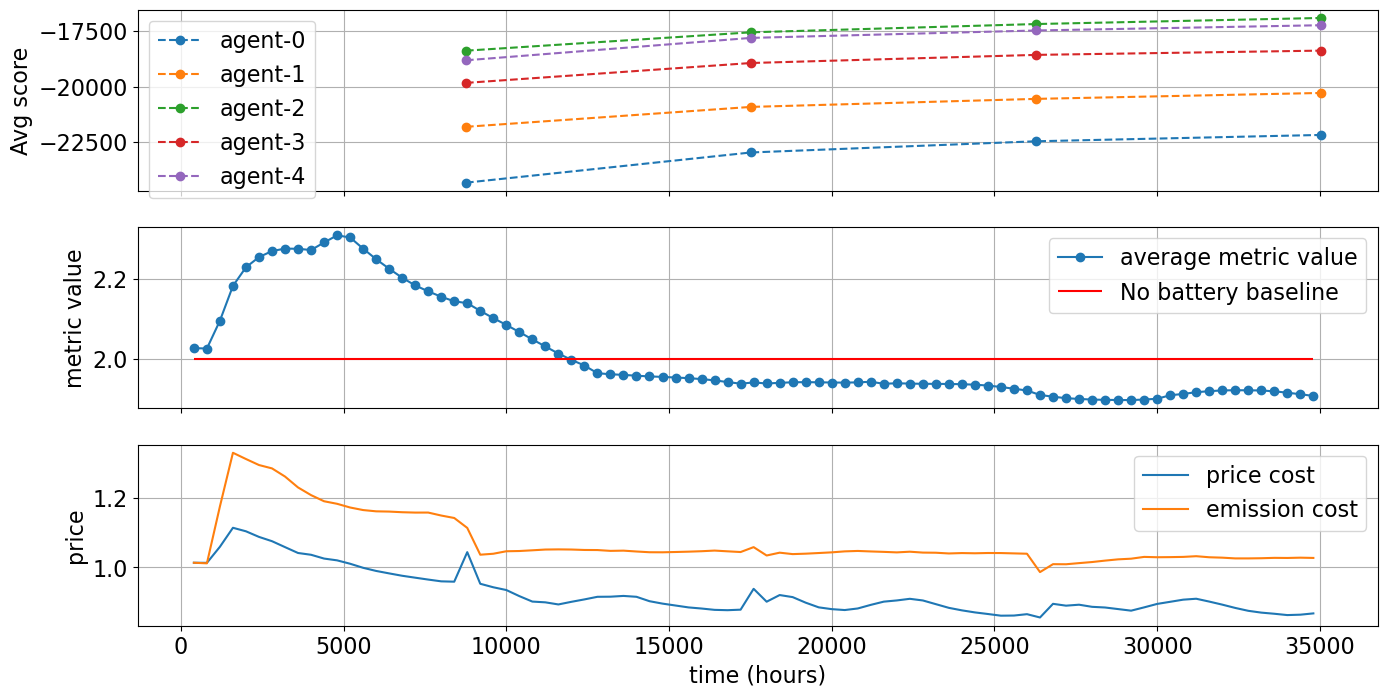

In [15]:
plot_scores(rl_coordinator, TrainConstants)

### How to Load Agents From Checkpoints
In order to load agent, one can use the following command

`rl_coordinator.load_checkpoints()`

For loading agents from a directory different from `tmp`, run the following command

`rl_coordinator.load_checkpoints(new_directory_path=<path_to_directory>)`

In [16]:
rl_coordinator.load_checkpoints(new_directory_path='tmp/best')

new directory was set for loading.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 0.
new directory was set for loading.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 1.
new directory was set for loading.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 2.
new directory was set for loading.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 3.
new directory was set for loading.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 4.


### Agents Evaluation Process

In [17]:
from utils import evaluate

# Define the number of episodes being played and the schema
class EvalConstants:
    episodes = 1
    compute_metric_interval = 400
    schema_path = './data/citylearn_challenge_2022_phase_1/schema.json'
    evaluation_days = episodes * 365 + 354
    sac_params = sac_params()

### Evaluation

In [18]:
shared_agent = True
verbos = False
loading_dir = 'tmp'
env, rl_coordinator = evaluate(EvalConstants,
                               shared_agent=shared_agent,
                               verbose=verbos,
                               loading_dir=loading_dir)

Starting local evaluation
Initialize a shared decision maker for all agents.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 0.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 1.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 2.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 3.
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
load networks for agent 4.
Episode complete: 1 | Latest episode metrics: {'price_cost': 0.880330152656729, 'emission_cost': 0.95544861851017

### Plot Evaluation Results
Below is a plot of the district's dynamics in a full single episode. We will explain the behaviour in more detail in the next (zoom) plot.

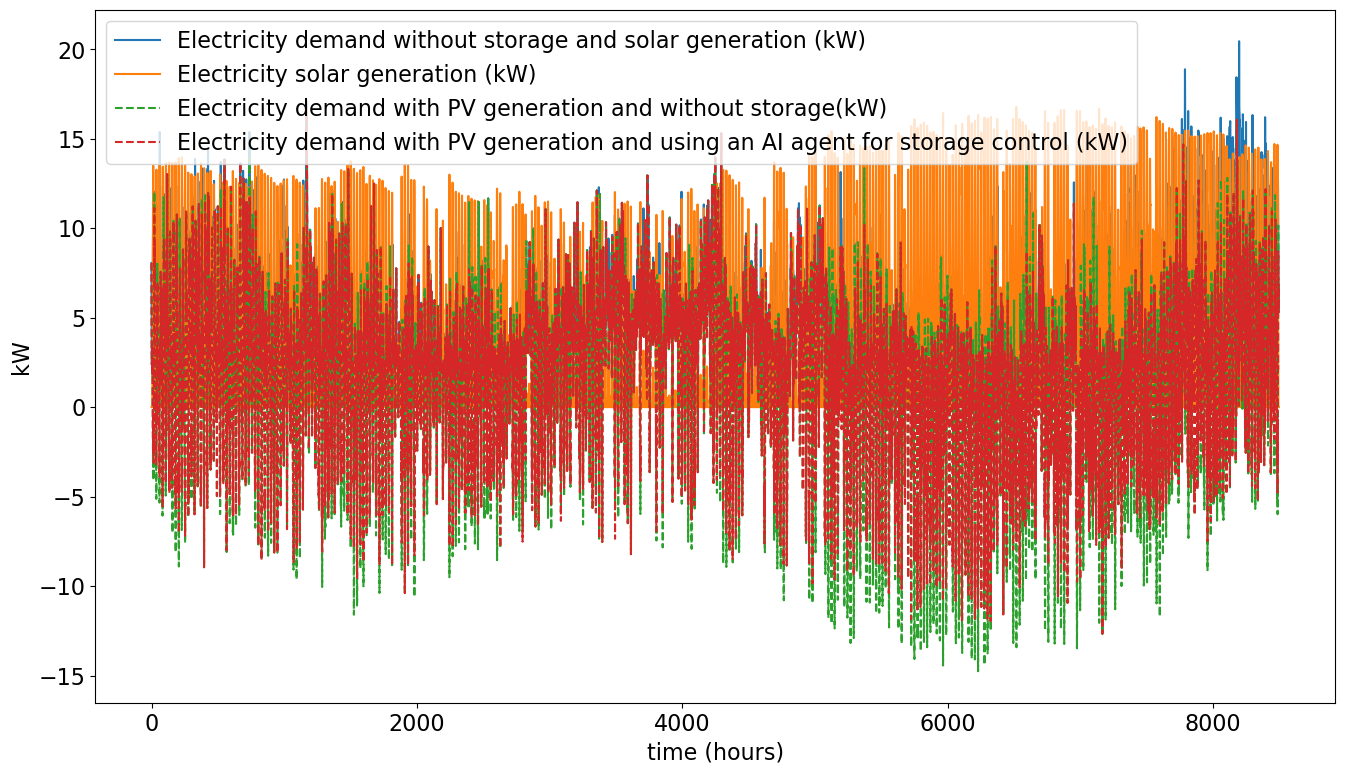

In [19]:
sim_period = [0, rl_coordinator.num_steps]
interval = range(sim_period[0], sim_period[1])
plot_interval_results(env, sim_period)

### Alanyze the Agents' Storage Behaviour
#### Evaluation analysis
Next, we analyze the agents' behavior in the last 200 hours of the evaluation. Good behavior is one in which the consumption with storage (red) is bounded by the consumption without storage (green) because it is highly correlated to low utility values. This makes sense because high positive consumption values have high CO2 emission rates, and high negative consumption values, although having high profit, results in the battery's low energy, which results in future high positive consumption values.

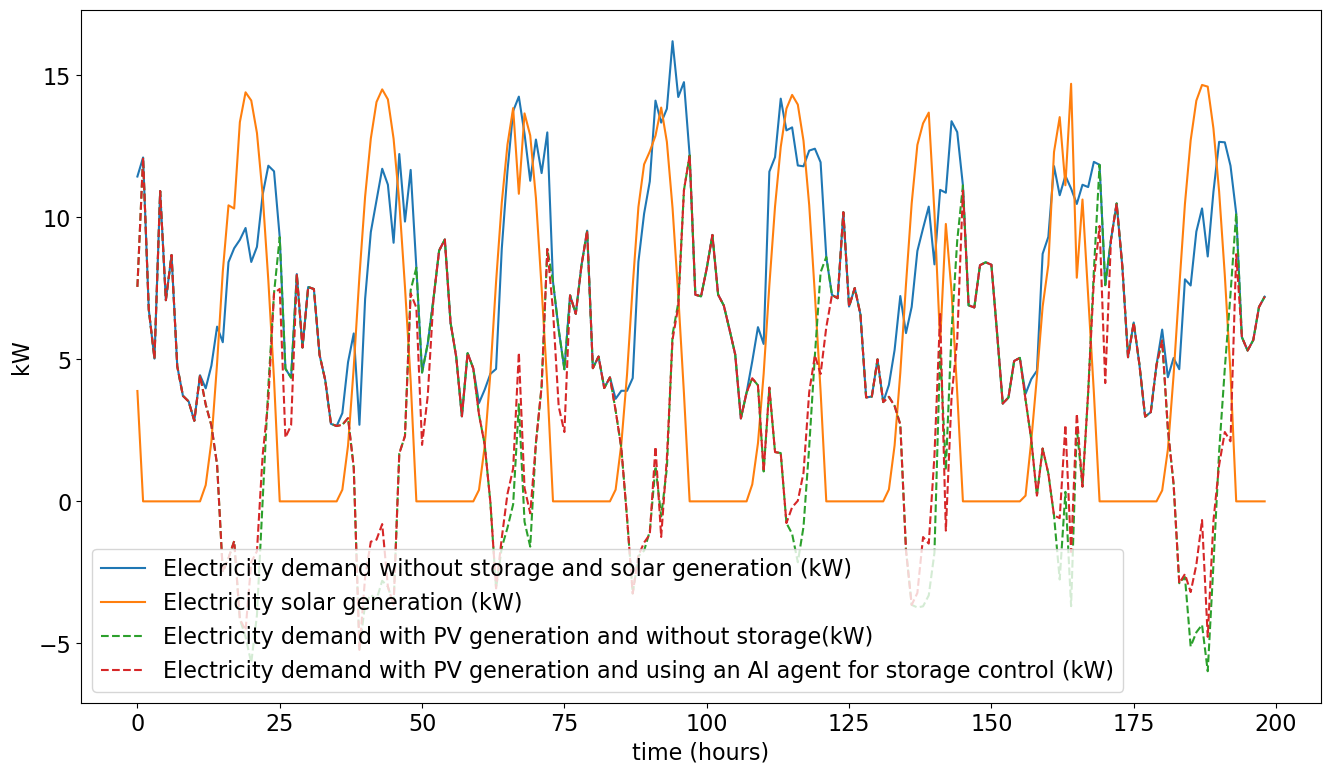

In [20]:
plot_interval_results(env, [-200, -1])

## Conclusion

Examining the training curves and metrics, we see that the agents trained in the suggested framework can learn how to use their battery to contribute to electricity price cost and CO2 emission cost minimization compared to performance without a battery. It is important to note that the results presented in this notebook were obtained while training the agents on a laptop with 16 GB RAM for 10 episodes of the environment. Therefore, we believe that with improved hardware, one could potentially obtain better results by optimizing the SAC parameters. Also, from the extracted learning curve, we conclude that it might be possible to increase performance by using a learning rate scheduler in order to decrease the learning rate mid-learning and find better local minima point and convergence behavior.

## References
[1] [Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor](https://arxiv.org/abs/1801.01290)